# YOLO Object Detection in Images

In [1]:
import numpy as np
import time
import cv2
from matplotlib import pyplot as plt
import nms

plt.rcParams['figure.figsize'] = [10, 5]

In /Users/Nikhiln/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/Nikhiln/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/Nikhiln/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/Nikhiln/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/Nikhiln/opt/anaconda3/lib/

In [2]:
# Load COCO class labels
labelsPath = './yolo-coco/coco.names'
labels = open(labelsPath).read().strip().split('\n')
print("Number of labels:", len(labels))

Number of labels: 25


In [3]:
# Associate each label with a certain color
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [4]:
# Constants to use with YOLO
min_confidence = 0.5
min_threshold = 0.3

In [5]:
configPath = './yolo-coco/yolov3.cfg'
weightsPath = './yolo-coco/yolov3.weights'

# Load YOLO Object detector trained on COCO dataset
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

## Test DNN on Image

In [6]:
# Load an image
image = cv2.imread('./data_object_image_2/testing/image_2/000061.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
(height, width) = image.shape[:2]

In [7]:
# Get output layer names from YOLO Model
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [8]:
# Construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

In [9]:
%%time
layerOutputs = net.forward(ln)

CPU times: user 2.12 s, sys: 178 ms, total: 2.3 s
Wall time: 679 ms


In [10]:
boxes = [] # Bounding boxes
confidences = [] # Confidence values assigned to an object
classIDs = [] # objects' class label

In [10]:
def get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height):
    for output in layerOutputs:
        for detection in output:
            # Get classID and confidence from object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # Filter out weak predictions
            if confidence > min_confidence:
                box = detection[0:4] * np.array([width, height, width, height])
                (centerX, centerY, box_width, box_height) = box.astype('int')

                # Get top left corner of the box
                x = int(centerX - (box_width/2))
                y = int(centerY - (box_height/2))

                # Update boxes, confidences, and classIDs
                boxes.append([x, y, int(box_width), int(box_height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

In [12]:
get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height)
print(classIDs) # Car detected

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [13]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, min_threshold)

In [11]:
def draw_boxes(idxs, image, boxes, classIDs, confidences):
    if len(idxs) > 0: # If object was detected only
        for i in idxs.flatten():
            # Get bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # Draw bounding box
            try:
                color = [int(c) for c in colors[classIDs[i]]]
                cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
                text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
                cv2.putText(image, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            except IndexError:
                print("Invalid ID " + str(classIDs[i]))

In [15]:
print(boxes)

[[200, 181, 255, 66], [960, 69, 273, 304], [84, 186, 289, 118], [953, 121, 292, 247], [-3, 183, 266, 202], [956, 151, 289, 226], [-6, 193, 268, 192], [357, 168, 124, 49], [355, 168, 131, 47], [393, 169, 93, 45], [367, 168, 130, 46], [616, 171, 88, 46], [630, 172, 83, 47], [246, 174, 201, 80], [701, 182, 166, 61], [707, 177, 160, 76], [249, 180, 196, 73], [731, 188, 122, 67], [705, 191, 162, 62], [714, 184, 152, 75], [97, 184, 265, 136], [137, 189, 229, 125], [0, 199, 247, 169], [0, 200, 243, 181], [611, 173, 42, 35]]


In /Users/Nikhiln/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/Nikhiln/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/Nikhiln/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/Nikhiln/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/Nikhiln/opt/anaconda3/lib/

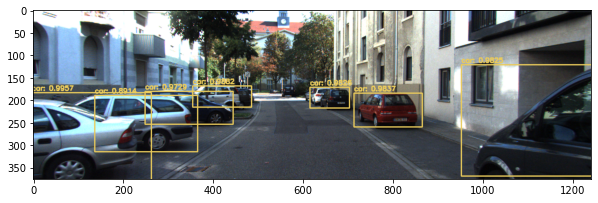

In [16]:
draw_boxes(idxs, image, boxes, classIDs, confidences)
plt.imshow(image)
plt.show()

## Concat into Method

In [177]:
def object_detect(image_path):
    # Get image and details
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (height, width) = image.shape[:2]
    
    # Get output layer names from YOLO Model
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # Construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    # Forward pass through YOLO Network
    layerOutputs = net.forward(ln)
    
    boxes = [] # Bounding boxes
    confidences = [] # Confidence values assigned to an object
    classIDs = [] # objects' class label
    get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height)
    #print(classIDs)
    #print(boxes)
    
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, min_threshold)
    
    draw_boxes(idxs, image, boxes, classIDs, confidences)
    plt.imshow(image)
    plt.show()

[[872, 124, 58, 49], [1050, 112, 175, 118], [1045, 114, 187, 129], [1063, 115, 172, 132], [20, 221, 80, 64], [0, 214, 52, 112], [1, 222, 49, 114], [876, 123, 51, 47], [74, 217, 47, 32]]


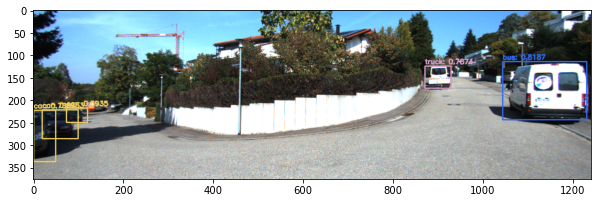

In [147]:
image_path_2 = './data_object_image_2/training/image_2/000061.png'
object_detect(image_path_2)

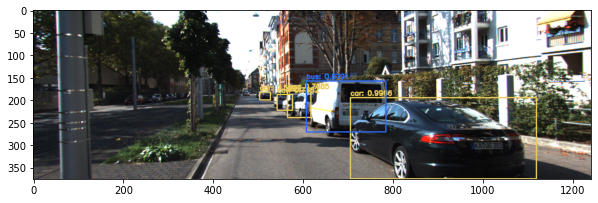

In [19]:
image_path_3 = './data_object_image_2/testing/image_2/001061.png'
object_detect(image_path_3)

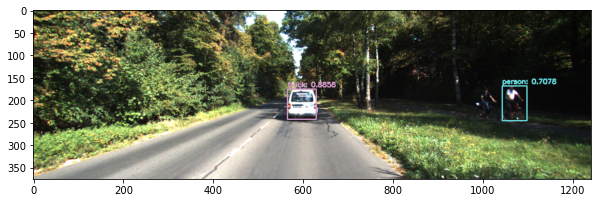

In [20]:
image_path_4 = './data_object_image_2/testing/image_2/007512.png'
object_detect(image_path_4)

## Compare YOLO Boxes with True Boxes

In [142]:
def get_yolo_boxes(image_path):
    # Get image and details
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    (height, width) = image.shape[:2]
    
    # Get output layer names from YOLO Model
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    
    # Construct a blob from the image
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    # Forward pass through YOLO Network
    layerOutputs = net.forward(ln)
    
    boxes = [] # Bounding boxes
    confidences = [] # Confidence values assigned to an object
    classIDs = [] # objects' class label
    get_boxes_and_confidences(layerOutputs, boxes, confidences, classIDs, width, height)
    return boxes, confidences

In [27]:
image_path_2 = './data_object_image_2/training/image_2/000061.png'
get_yolo_boxes(image_path_2)

[[872, 124, 58, 49], [1050, 112, 175, 118], [1045, 114, 187, 129], [1063, 115, 172, 132], [20, 221, 80, 64], [0, 214, 52, 112], [1, 222, 49, 114], [876, 123, 51, 47], [74, 217, 47, 32]]
[0.7874054908752441, 0.5668146014213562, 0.8186833262443542, 0.8098448514938354, 0.676322340965271, 0.6378733515739441, 0.7804141044616699, 0.5018944144248962, 0.5934586524963379]


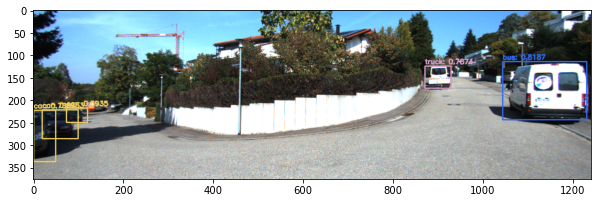

In [145]:
object_detect(image_path_2)

In [29]:
def get_actual_boxes(mask_directory):
    bound_boxes = []
    with open(mask_directory) as f:
        content = f.readlines()
    contents = [x.split() for x in content]
    for content in contents:
        obj = content[0]
        if (obj in ['Car', 'Truck', 'Van']): # Get pixels containing a vehicle
            start_col = int(float(content[4]))
            start_row = int(float(content[5]))
            end_col = int(float(content[6]))
            end_row = int(float(content[7]))
            bound_boxes.append((start_row, end_row, start_col, end_col))
    return bound_boxes

In [31]:
mask_path_2 = './data_object_image_2/training/label_2/000061.txt'
get_actual_boxes(mask_path_2)

[(105, 249, 1054, 1241),
 (212, 328, 0, 41),
 (217, 254, 69, 112),
 (218, 297, 0, 93),
 (123, 169, 884, 923)]

In [55]:
def draw_actual_boxes(image, boxes):
    for i in range(0, len(boxes)):
        # Get bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # Draw bounding box
        color = (255,0,0)
        cv2.rectangle(image, (boxes[i][2], boxes[i][0]), (boxes[i][3], boxes[i][1]), color, 2)

In [56]:
def get_and_draw_actual_boxes(img_path, mask_directory):
    # Get image and details
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get boxes from label data
    boxes = get_actual_boxes(mask_directory)
    #print(classIDs)
    #print(boxes)
    
    draw_actual_boxes(image, boxes)
    plt.imshow(image)
    plt.show()

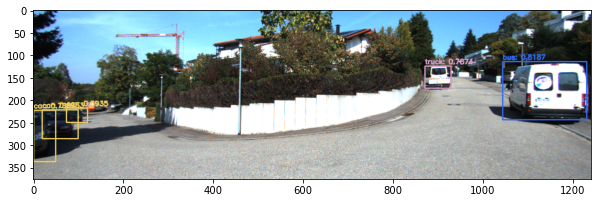

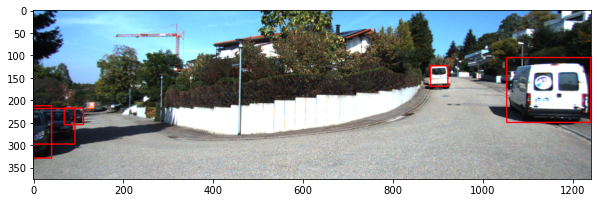

In [66]:
image_path_2 = './data_object_image_2/training/image_2/000061.png'
mask_path_2 = './data_object_image_2/training/label_2/000061.txt'

object_detect(image_path_2)
get_and_draw_actual_boxes(image_path_2, mask_path_2)

In [173]:
def bb_intersection_over_union(image_path, mask_path):
    predicted_boxes, confidences = get_yolo_boxes(image_path) # x_start, y_start, x_end, y_end
    best_box_indices = nms.boxes(predicted_boxes, confidences, nms_threshold=0.6)
    # Instead of (x, y, w, h), return (x, y, x+w, y+h)
    for box in predicted_boxes:
        box[2] = box[2] + box[0]
        box[3] = box[3] + box[1]
    predicted_boxes = [predicted_boxes[i] for i in best_box_indices]
    
    actual_boxes = get_actual_boxes(mask_path_2) # y_start, y_end, x_start, x_end
    # Rearrange actual_boxes to fit the same format
    actual_boxes_reordered = []
    actual_box_order = [2, 0, 3, 1]
    for box in actual_boxes:
        actual_boxes_reordered.append((box[2], box[0], box[3], box[1]))
    
    # Sort rectangles in each list
    predicted_boxes = sorted(predicted_boxes, key=lambda x: x[0])
    actual_boxes_reordered = sorted(actual_boxes_reordered, key=lambda x: x[0])
    
    print("Predicted Boxes:", predicted_boxes)
    print("Actual Boxes:", actual_boxes_reordered)
    
    # Calculate IOU
    for i in range(0, len(predicted_boxes)):
        boxA = predicted_boxes[i]
        boxB = actual_boxes_reordered[i]
        
        xA = max(boxA[0], boxB[0])
        yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2])
        yB = min(boxA[3], boxB[3])
        
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
        
        iou = interArea / float(boxAArea + boxBArea - interArea)
        print(iou)

In [174]:
image_path_2 = './data_object_image_2/training/image_2/000061.png'
mask_path_2 = './data_object_image_2/training/label_2/000061.txt'

bb_intersection_over_union(image_path_2, mask_path_2)

Predicted Boxes: [[1, 222, 50, 336], [20, 221, 100, 285], [74, 217, 121, 249], [872, 124, 930, 173], [1045, 114, 1232, 243]]
Actual Boxes: [(0, 212, 41, 328), (0, 218, 93, 297), (69, 217, 112, 254), (884, 123, 923, 169), (1054, 105, 1241, 249)]
0.6989007487653338
0.6031347962382445
0.6536312849162011
0.6153846153846154
0.8185015828350334


Predicted Boxes: [[0, 207, 357, 375], [386, 186, 499, 263]]
Actual Boxes: [(0, 203, 365, 374), (378, 183, 507, 276)]
0.9499921023534986
0.7276595744680852


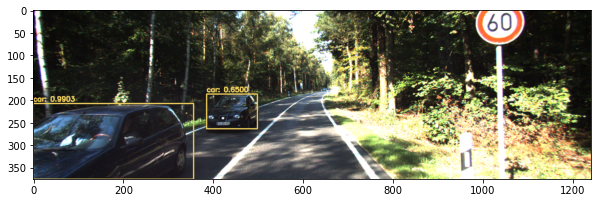

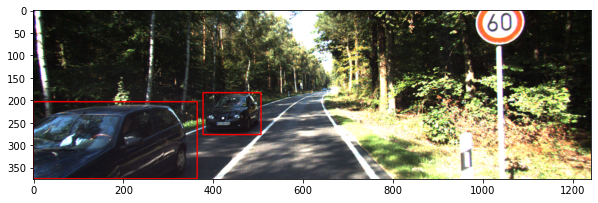

In [178]:
image_path_2 = './data_object_image_2/training/image_2/000044.png'
mask_path_2 = './data_object_image_2/training/label_2/000044.txt'

bb_intersection_over_union(image_path_2, mask_path_2)

object_detect(image_path_2)
get_and_draw_actual_boxes(image_path_2, mask_path_2)

Predicted Boxes: [[180, 197, 594, 305], [957, 200, 1014, 295]]
Actual Boxes: [(215, 190, 586, 316), (943, 188, 1241, 314)]
0.7808052993395082
0.14663050061886077


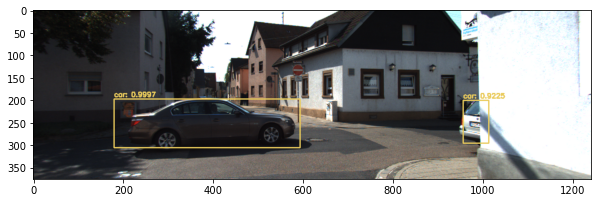

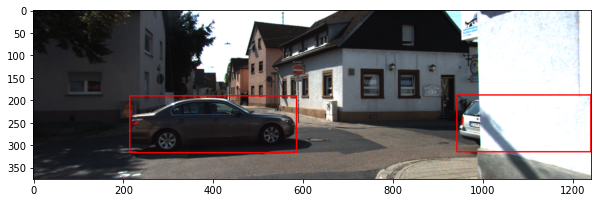

In [179]:
image_path_2 = './data_object_image_2/training/image_2/000215.png'
mask_path_2 = './data_object_image_2/training/label_2/000215.txt'

bb_intersection_over_union(image_path_2, mask_path_2)

object_detect(image_path_2)
get_and_draw_actual_boxes(image_path_2, mask_path_2)

## YOLO Object Detection on Video

In [21]:
import imutils

In [ ]:
# Get output layer names from YOLO Model
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [46]:
vs = cv2.VideoCapture('./kitti-example-video.avi')
writer = None
(W, H) = (None, None)

try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("{} total frames in video".format(total))
except:
    print("Could not determine # of frames in video")
    print("No approx. completion time can be provided")
    total = -1 

154 total frames in video


In [47]:
# Process frames one by one
while True:    
    # Read the next frame
    (grabbed, frame) = vs.read()
    if not grabbed:
        break
    if W is None or H is None:
        (H, W) = frame.shape[:2]
        
    blob_video = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob_video)
    end = time.time()
    layerOutputs_video = net.forward(ln)

    boxes_video = []
    confidences_video = []
    classIDs_video = []
    
    get_boxes_and_confidences(layerOutputs_video, boxes_video, confidences_video, classIDs_video, W, H)
    
    idxs_video = cv2.dnn.NMSBoxes(boxes_video, confidences_video, min_confidence, min_threshold)
    
    draw_boxes(idxs_video, frame, boxes_video, classIDs_video, confidences_video)
    
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter("./kitti-example-box.avi", fourcc, 2, (frame.shape[1], frame.shape[0]), True)
        #if total > 0:
        #    elapsedTime = end - start
        #    print("Single frame took {:.4f} seconds".format(elapsedTime))
    writer.write(frame)
        
print("Finished saving video")
writer.release()
vs.release()

Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 25
Invalid ID 62
Finished saving video


In [38]:
colors

array([[102, 220, 225],
       [ 95, 179,  61],
       [234, 203,  92],
       [  3,  98, 243],
       [ 14, 149, 245],
       [ 46, 106, 244],
       [ 99, 187,  71],
       [212, 153, 199],
       [188, 174,  65],
       [153,  20,  44],
       [203, 152, 102],
       [214, 240,  39],
       [121,  24,  34],
       [114, 210,  65],
       [239,  39, 214],
       [244, 151,  25],
       [ 74, 145, 222],
       [ 14, 202,  85],
       [145, 117,  87],
       [184, 189, 221],
       [116, 237, 109],
       [ 85,  99, 172],
       [226, 153, 103],
       [235, 146,  36],
       [151,  62,  68]], dtype=uint8)